# Import Libraries

In [1]:
import os
import csv 
import math
import joblib
import pickle
import warnings
import copy
from tqdm import tqdm_notebook as tqdm

import pandas as pd
import numpy as np
import statistics as stat
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_validate

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

from sklearn.svm import SVR
from scipy import stats

warnings.filterwarnings('ignore')

# Splitting Data

## Concate data padel with target

In [17]:
# Import data from csv into pandas DataFrame
dfPadel = pd.read_csv("data/padel_desc.csv")
dtRawIC50 = pd.read_csv("data/pIC50_target.csv")
dtIC50 = dtRawIC50['pIC50']

# Concatenate data dataframe (Padel,Cdk,Target)
df = pd.concat([dfPadel,dtIC50], axis=1)
df = df.drop(columns = ['Name'])

# Export concatenated data
# df.to_csv (r'data\all_data.csv',index=False, header=True,sep=',')
df.head()

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,P2s,E1s,E2s,E3s,Ts,As,Vs,Ks,Ds,pIC50
0,0,0.4097,0.167854,110.4259,55.335067,17,19,46,27,19,...,0.190703,0.572743,0.489742,0.358826,24.557550,110.436715,216.300654,0.658011,1.421311,4.456
1,0,1.2316,1.516839,114.4661,58.428653,17,19,49,28,21,...,0.262612,0.587732,0.498935,0.275692,24.658242,128.389370,221.988665,0.569236,1.362359,4.347
2,0,-0.3086,0.095234,114.1927,57.101860,17,19,48,28,20,...,0.278363,0.612412,0.492582,0.283494,24.883109,134.783818,231.750906,0.546311,1.388489,6.046
3,0,-0.6209,0.385517,123.2672,62.757446,17,19,53,31,22,...,0.274180,0.582830,0.444859,0.349300,26.949883,163.786100,332.971005,0.530884,1.376989,6.710
4,0,-0.8872,0.787124,124.9481,63.722239,17,19,54,31,23,...,0.282594,0.630230,0.461287,0.290526,28.080637,176.370332,335.460364,0.530389,1.382042,6.947


## Split Train & Test + PCC Correlation

In [ ]:
%%DISBAND
# Loop for finding correlation combination
# for i in range(10):
#     # Divide into training data and test data
#     dfTrain = df.sample(frac=0.8,random_state=i)
#     dfTest = df.drop(dfTrain.index)

#     # Find 100 descriptors with strongest correlation with pIC50
#     train_corr = dfTrain.corr()
#     train_corr = train_corr.iloc[:-1,[-1]]
#     train_corr.sort_values("pIC50", ascending = False, inplace = True)
#     train_corr = train_corr.iloc[:100,:]

#     # Check for WTPT-3 only
#     if train_corr.index[0] == "WTPT-3":
#         print("i: %04d"%i)
#         # Dump training and test data
#         dfTrain.to_pickle("./pickle/train_%04d.pkl"%i)
#         dfTest.to_pickle("./pickle/test_%04d.pkl"%i)
#         # Dump correlation data
#         train_corr.to_csv(r'data/dataCorr_%04d.pkl.csv'%i, index= None, header = True)
#         # Dump list of 100 strongest des
#         corr_100 = train_corr.index.values.tolist()[:100]
#         with open('./pickle/corr100_%04d.pkl'%i, 'wb') as f:
#             pickle.dump(corr_100, f)

In [42]:
# Loop for finding correlation combination
dfTrain = df.sample(frac=0.8,random_state=5)
dfTest = df.drop(dfTrain.index)

# dfTrain.to_csv('./data/train_05.csv')
# dfTest.to_csv('./data/test_05.csv')

In [72]:
### Remove low variance desc
X_train = pd.read_csv("data/train_05.csv")
X_train_target = X_train.loc[:,'pIC50']
var_ = X_train.var()
var_ = pd.DataFrame(var_, columns=["var"])
var_ = var_[var_["var"] > 0.95]
desc_name = var_.index.values.tolist()
X_train = X_train.loc[:,desc_name]

### Append pcc again
X_train = X_train.join(X_train_target)
X_train.head()

### Find 100 descriptors with strongest correlation with pIC50
pcc = X_train.corr().iloc[:-1,[-1]]
pcc.pIC50 = pcc.pIC50.apply(lambda x: np.abs(x))
pcc.sort_values("pIC50", ascending = False, inplace = True)
pcc_list = pcc.iloc[:100,:]
# pcc_list.index.values.tolist()[:100]

# joblib.dump(pcc_list.index.values.tolist()[:100],'./p/05_neue/corr_withlowvar.pkl')
# pcc_list.to_csv('.data/corr_withlowvar.csv')

# Feature Selection : SA + K-Fold

## Simulated Annealing

### SA Functions

In [84]:
def acceptanceProbability (bestMSE, newMSE, temp , K):
        # If the new solution is worse, calculate an acceptance probability
        return np.exp( K * (newMSE - bestMSE) / temp)
    
def calcMSE(combDesc, x_train, x_val, y_train, y_val, model):
    x_train_slice = x_train.iloc[:,combDesc]
    x_val_slice = x_val.iloc[:,combDesc]
    
    scaler = MinMaxScaler()
    scaler.fit(x_train_slice)
    scale_x_train = scaler.transform(x_train_slice)
    scale_x_val = scaler.transform(x_val_slice)
    
    model.fit(scale_x_train, y_train)
    y_pred = model.predict(scale_x_val)
    return mean_squared_error(y_val, y_pred)

### SA Prepare Data

In [85]:
corr = joblib.load('./p/05_low/corr_withlowvar.pkl')
dftrain = joblib.load('./p/05_low/train.pkl')

#change index for data
corr_100 = corr
dft = dftrain

train = dft.loc[:,corr_100]
train["pIC50"] = dft.iloc[:, -1]
descName = train.columns.values

trained, val = train_test_split(train, test_size = 0.2, random_state = 45)

x_train = trained.iloc[:,:-1]
x_val = val.iloc[:,:-1]
y_train = trained.iloc[:, [-1]]
y_val = val.iloc[:,[-1]]

model = LinearRegression()
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((59, 100), (15, 100), (59, 1), (15, 1))

### SA algorithm

In [86]:
### 50 ITERATION
combos = [5,10,15,20,25]

for k in tqdm(range(5)):

    ## INTO DE SA DE LA'SOIN MODDED ##
    descNum = combos[k]
    descMSE_descNum = []

    for j in tqdm(range(20)):
        # Initialize Values
        initTemp, temp = 100, 100
        tempEnd = 0.1
        cooling_rate = 0.98
        iteration = 50

        # Simulated Annealing
        bestList = []
        bestMSEList = []
        tempChange = []

        # Initialize solution & Best MSE (Random descNum descriptor)
        bestSol = np.random.choice(x_train.shape[1],descNum, replace=False)
        bestSol = list(bestSol)
        bestSol.sort()

        # First MSE
        bestMSE = calcMSE(bestSol, x_train, x_val, y_train, y_val, model)
        while temp > tempEnd:
            for i in range(iteration):

                # Create new solution & new MSE
                newSol = np.random.choice(x_train.shape[1], descNum, replace=False)
                newMSE = calcMSE(newSol, x_train, x_val, y_train, y_val, model)
                
                # New solution is better based on MSE value
                if newMSE < bestMSE :
                    bestMSE = newMSE
                    bestSol = newSol
                    #bestList.append([bestMSE,bestSol])
                    #tempChange.append(temp)
                    #bestMSEList.append(bestMSE)
                    
                #Probability to accept bad solution
                else :
                    deltaMSE = newMSE - bestMSE
                    K = (initTemp * np.log(0.8)) / deltaMSE
                    
                    if acceptanceProbability (bestMSE, newMSE, temp , K) > np.random.rand(1,1):
                        bestMSE = newMSE
                        bestSol = newSol
                        #bestList.append([bestMSE,bestSol])
                        #tempChange.append(temp)
                        #bestMSEList.append(bestMSE)
            
            bestList.append([bestMSE,bestSol])
            tempChange.append(temp)
            bestMSEList.append(bestMSE)
            temp *= cooling_rate

        descMSE_descNum.append([bestList[-1][0],bestList[-1][1],bestMSEList,tempChange])
       
    # Extracting results
    df_SA = pd.DataFrame(descMSE_descNum)
    df_SA.columns=["MSE","solution","growth", "temp"]
    df_SA.reset_index(drop=True, inplace= True)

    # Sort values
    df_SA_sort = df_SA.copy()
    df_SA_sort.sort_values('MSE', inplace=True)

    # Get Descriptors name    
    bestDescriptor = []
    for i in df_SA_sort.iloc[0,1]:
        bestDescriptor.append(descName[i])

    df_SA.to_pickle(f"./p/05_low/raw_{combos[k]}.pkl")
    joblib.dump(bestDescriptor, f"./p/05_low/best_{combos[k]}.pkl")

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [2:21:34<00:00, 1698.96s/it]


## K-Fold

In [2]:
# Preparing data
dataset = joblib.load('./p/05_low/train.pkl')

kernel = "linear" # --> diganti dengan rentang rbf, poly, sigmoid
svr_model = SVR(kernel=kernel, gamma="scale")
y_train = dataset.iloc[:,[-1]].values
y_train = y_train.ravel()
cv_list = {}

In [3]:
# K-Fold
combos=[5,10,15,20,25]
for i in tqdm(range(5)):
    sel_desc = joblib.load(f"./p/05_low/best_{combos[i]}.pkl")
    X_train = dataset.loc[:,sel_desc].values
    cv_score = cross_validate(svr_model, X_train, y_train, cv=10, scoring=('r2', 'neg_mean_squared_error'))
    mse_score = [-x for x in cv_score["test_neg_mean_squared_error"]]
    mse_score = np.average(mse_score)
    cv_list[i] = mse_score

In [4]:
joblib.dump(cv_list, "./p/05_low/cv_list_{}.p".format(kernel))

['./p/05_low/cv_list_linear.p']

# Model Development : SVR


## Preparing Data

In [10]:
# Load train and test data
# IMPORTANT! LOOK AT THE LOADED FILES
train = joblib.load('./p/05_low/train.pkl', 'rb')
test = joblib.load('./p/05_low/test.pkl', 'rb')

# Create params for kernels
param={
            'C': [0.1, 1, 10, 100, 1000],
            'gamma': ['auto','scale'],
            'degree': [1, 2, 3, 4, 5],
            'epsilon':[0.1, 1, 10, 100, 1000]
}

# Create list of descriptors set
# IMPORTANT! MUST BE SAME AS LOADED TRAIN & TEST
bd_list = []
bd_5 = joblib.load('./p/05_low/best_5.pkl')

bd_list.extend([bd_5])

## SVR : RBF 

In [229]:
r2_rbf = pd.DataFrame(columns=['desc','C','Gamma','Epsilon','r2_train','r2_test','mse_train','mse_test','train_pred','test_pred'])

for i in tqdm(range(len(bd_list))):
    
    # Preparation data x & y
    x_train = train.loc[:,bd_list[i]]
    x_test = test.loc[:,bd_list[i]]
    y_train = train.iloc[:, [-1]]
    y_test = test.iloc[:,[-1]]
    
    # Feature scaler Using MinMaxScaler()
    scaler = MinMaxScaler()
    scaler.fit(x_train)
    scale_x_train = scaler.transform(x_train)
    scale_x_test = scaler.transform(x_test)
    
    # Search best params for SVR()
    gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid=param,
        cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    gsc.fit(scale_x_train, y_train)
    param_c = gsc.best_params_['C']
    param_gamma = gsc.best_params_['gamma']
    param_epsilon = gsc.best_params_['epsilon']
    
    # Assign best params to model
    model = SVR(C=param_c, kernel="rbf", gamma=param_gamma, epsilon=param_epsilon)
    model.fit(scale_x_train, y_train)
    
    #Calculate prediction
    y_train_pred = model.predict(scale_x_train)
    y_test_pred = model.predict(scale_x_test)

    #Calculate r2 score
    r2_train = r2_score(y_train,y_train_pred)
    r2_test = r2_score(y_test,y_test_pred)
    
    #Calculate MSE
    mse_train = mean_squared_error(y_train,y_train_pred)
    mse_test = mean_squared_error(y_test,y_test_pred)
    
    r2_rbf = r2_rbf.append(pd.Series([len(bd_list[i]),param_c, param_gamma, param_epsilon, r2_train, r2_test, mse_train, mse_test, y_train_pred, y_test_pred], index=r2_rbf.columns ), ignore_index=True)

In [232]:
joblib.dump(r2_rbf, './p/05_low/md_rbf.pkl')
# r2_rbf = joblib.load('./p/0006_n1/r2_rbf_neue.pkl')
r2_rbf

,desc,C,Gamma,Epsilon,r2_train,r2_test,mse_train,mse_test,train_pred,test_pred
0,5,10,scale,0.1,0.791062,0.572826,0.159999,0.240162,"[6.060797071606271, 7.319913330755074, 5.92458...","[7.208959873075485, 7.391254510466805, 6.51627..."


In [8]:
%%DISBAND_SIGMOID_HEAD
## SVR : Sigmoid

UsageError: Cell magic `%%DISBAND_SIGMOID_HEAD` not found.


In [109]:
# r2_sig = pd.DataFrame(columns=['desc','C','Gamma','Epsilon','r2_train','r2_test','mse_train','mse_test','train_pred','test_pred'])

# for i in tqdm(range(len(bd_list))):
    
#     # Preparation data x & y
#     x_train = train.loc[:,bd_list[i]]
#     x_test = test.loc[:,bd_list[i]]
#     y_train = train.iloc[:, [-1]]
#     y_test = test.iloc[:,[-1]]
    
#     # Feature scaler Using MinMaxScaler()
#     scaler = MinMaxScaler()
#     scaler.fit(x_train)
#     scale_x_train = scaler.transform(x_train)
#     scale_x_test = scaler.transform(x_test)
    
#     # Search best params for SVR()
#     gsc = GridSearchCV(
#         estimator=SVR(kernel='sigmoid'),
#         param_grid=param,
#         cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

#     gsc.fit(scale_x_train, y_train)
#     param_c = gsc.best_params_['C']
#     param_gamma = gsc.best_params_['gamma']
#     param_epsilon = gsc.best_params_['epsilon']
    
#     # Assign best params to model
#     model = SVR(C=param_c, kernel="sigmoid", gamma=param_gamma, epsilon = param_epsilon)
#     model.fit(scale_x_train, y_train)
    
#     #Calculate prediction
#     y_train_pred = model.predict(scale_x_train)
#     y_test_pred = model.predict(scale_x_test)

#     #Calculate r2 score
#     r2_train = r2_score(y_train,y_train_pred)
#     r2_test = r2_score(y_test,y_test_pred)
    
#     #Calculate MSE
#     mse_train = mean_squared_error(y_train,y_train_pred)
#     mse_test = mean_squared_error(y_test,y_test_pred)
    
#     r2_sig = r2_sig.append(pd.Series([len(bd_list[i]),param_c, param_gamma, param_epsilon, r2_train, r2_test, mse_train, mse_test, y_train_pred, y_test_pred], index=r2_sig.columns ), ignore_index=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


## SVR : Linear

In [11]:
# %%DISBAND_LINEAR
r2_linear = pd.DataFrame(columns=['desc','C','degree','epsilon','r2_train','r2_test', 'mse_train','mse_test','train_pred','test_pred'])

for i in tqdm(range(len(bd_list))):
    
    # Preparation data x & y
    x_train = train.loc[:,bd_list[i]]
    x_test = test.loc[:,bd_list[i]]
    y_train = train.iloc[:, [-1]]
    y_test = test.iloc[:,[-1]]
    
    # Feature scaler Using MinMaxScaler()
    scaler = MinMaxScaler()
    scaler.fit(x_train)
    scale_x_train = scaler.transform(x_train)
    scale_x_test = scaler.transform(x_test)
    
    # Search best params for SVR()
    gsc = GridSearchCV(
        estimator=SVR(kernel='linear'),
        param_grid=param,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    gsc.fit(scale_x_train, y_train)
    param_c = gsc.best_params_['C']
    param_degree = gsc.best_params_['degree']
    param_epsilon = gsc.best_params_['epsilon']
    
    # Assign best params to model
    model = SVR(C=param_c, kernel="linear", degree=param_degree, epsilon = param_epsilon)
    model.fit(scale_x_train, y_train)
    
    #Calculate prediction
    y_train_pred = model.predict(scale_x_train)
    y_test_pred = model.predict(scale_x_test)

    #Calculate r2 score
    r2_train = r2_score(y_train,y_train_pred)
    r2_test = r2_score(y_test,y_test_pred)
    
    #Calculate MSE
    mse_train = mean_squared_error(y_train,y_train_pred)
    mse_test = mean_squared_error(y_test,y_test_pred)
    
    r2_linear = r2_linear.append(pd.Series([len(bd_list[i]),param_c, param_degree, param_epsilon, r2_train, r2_test, mse_train, mse_test, y_train_pred, y_test_pred], index=r2_linear.columns ), ignore_index=True)

In [12]:
# joblib.dump(r2_sig, './p/05_low/md_sigmoid.pkl')
# joblib.dump(r2_linear, './p/05_low/md_linear.pkl')
# r2_linear = joblib.load('./p/0006_n1/r2_linear_neue.pkl')
# r2_sig
r2_linear

,desc,C,degree,epsilon,r2_train,r2_test,mse_train,mse_test,train_pred,test_pred
0,5,1000,1,0.1,0.609213,0.574157,0.299254,0.239414,"[6.544111423712781, 7.644757412137512, 5.94295...","[6.6905752455242755, 6.896002775998756, 6.6284..."


## SVR : Polynomial 

In [95]:
r2_poly = pd.DataFrame(columns=['desc','C','degree','epsilon','r2_train','r2_test', 'mse_train','mse_test','train_pred','test_pred'])

for i in tqdm(range(len(bd_list))):
    
    # Preparation data x & y
    x_train = train.loc[:,bd_list[i]]
    x_test = test.loc[:,bd_list[i]]
    y_train = train.iloc[:, [-1]]
    y_test = test.iloc[:,[-1]]
    
    # Feature scaler Using MinMaxScaler()
    scaler = MinMaxScaler()
    scaler.fit(x_train)
    scale_x_train = scaler.transform(x_train)
    scale_x_test = scaler.transform(x_test)
    
    # Search best params for SVR()
    gsc = GridSearchCV(
        estimator=SVR(kernel='poly'),
        param_grid=param,
        cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    gsc.fit(scale_x_train, y_train)
    param_c = gsc.best_params_['C']
    param_degree = gsc.best_params_['degree']
    param_epsilon = gsc.best_params_['epsilon']
    
    # Assign best params to model
    model = SVR(C=param_c, kernel="poly", degree=param_degree, epsilon = param_epsilon)
    model.fit(scale_x_train, y_train)
    
    #Calculate prediction
    y_train_pred = model.predict(scale_x_train)
    y_test_pred = model.predict(scale_x_test)

    #Calculate r2 score
    r2_train = r2_score(y_train,y_train_pred)
    r2_test = r2_score(y_test,y_test_pred)
    
    #Calculate MSE
    mse_train = mean_squared_error(y_train,y_train_pred)
    mse_test = mean_squared_error(y_test,y_test_pred)
    
    r2_poly = r2_poly.append(pd.Series([len(bd_list[i]),param_c, param_degree, param_epsilon, r2_train, r2_test, mse_train, mse_test,y_train_pred, y_test_pred], index=r2_poly.columns ), ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [45:43<00:00, 2743.05s/it]


In [235]:
joblib.dump(r2_poly, './p/05_low/md_poly.pkl')
# r2_poly = joblib.load('./p/0006_n1/r2_poly_neue.pkl')
r2_poly

,desc,C,degree,epsilon,r2_train,r2_test,mse_train,mse_test,train_pred,test_pred
0,5,1000,2,0.1,0.72034,0.405353,0.214156,0.334317,"[6.371939982418214, 7.156051005682118, 5.67172...","[7.063206412598108, 7.20393888416004, 6.712992..."


In [237]:
%%DISBAND_R2PLOTS
# ### plot
# # x = np.arange(5,26,5)
# x = [5,10,15,20,25]

# # Note that even in the OO-style, we use `.pyplot.figure` to create the figure.
# fig, ax = plt.subplots(figsize=(8, 6), dpi=80)  # Create a figure and an axes.

# ax.plot(x, r2_rbf.loc[:,'mse_train'], label='MSE Train',marker='.',markersize=10, lw=2, color='b')
# ax.plot(x, r2_rbf.loc[:,'mse_test'], label='MSE Val', marker='.', markersize=10, lw=2, ls='dotted', color='b') 
# ax.plot(x, r2_linear.loc[:,'mse_train'], label='MSE Train', marker='.',markersize=10, lw=2,color='r')
# ax.plot(x, r2_linear.loc[:,'mse_test'], label='MSE Val', marker='.', markersize=10, lw=2, ls='dotted',color='r')
# ax.plot(x, r2_poly.loc[:,'mse_train'], label='MSE Train', marker='.', markersize=10, lw=2, color='g')
# ax.plot(x, r2_poly.loc[:,'mse_test'], label='MSE Val', marker='.', markersize=10, lw=2, ls='dotted', color='g')

# ax.set_xlabel('Number of Descriptors')
# ax.set_ylabel('MSE Score')
# # ax.set_title("SVR r2 score")  
# ax.set_xticks(x)
# plt.grid()
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# # plt.savefig('./p/0003/r2_models_numdesc.png', format='png', dpi=1000, bbox_inches="tight")    
# plt.show()

UsageError: Cell magic `%%DISBAND_R2PLOTS` not found.


# Model Validation

## Validation Functions

In [15]:
def r2_score(y, y_pred, y_train=None):
    sse = 0; sst = 0
    if y_train is None:        
        y_mean = np.mean(y)
    else:
        y_mean = np.mean(y_train)
    for i in range(len(y)):
        sse += (y[i] - y_pred[i]) ** 2
        sst += (y[i] - y_mean) ** 2
    r2_score = 1 - (sse / sst)
    return r2_score

def qsar_param(y, y_pred, d_r2m=True):
    results = []
    _, _, y = normalize(y)
    _, _, y_pred = normalize(y_pred)
    y_mean = np.mean(y); y_pred_mean = np.mean(y_pred)
    # calculate r2
    num = 0; den_1 = 0; den_2 = 0
    for i in range(len(y)):
        num += (y[i] - y_mean) * (y_pred[i] - y_pred_mean)
        den_1 += (y_pred[i] - y_pred_mean) ** 2
        den_2 += (y[i] - y_mean) ** 2
    r2 = num ** 2 / (den_1 * den_2)
    results = {"r2": r2}
    # calculate k and k_dash
    n_data = len(y)
    dot_ = 0; y_pred2 = 0; y2 = 0
    for i in range(n_data):
        dot_ += (y[i] * y_pred[i])
        y_pred2 += y_pred[i] ** 2
        y2 += y[i] ** 2
    k = np.sum(dot_) / np.sum(y_pred2)
    k_dash = np.sum(dot_) / np.sum(y2)
    results["k"] = k
    results["k_dash"] = k_dash
    # calculate r2_0 and r2_0_dash
    num = 0; num_dash = 0; den = 0; den_dash = 0
    for i in range(n_data):
        num += (y[i] - (k * y_pred[i])) ** 2
        num_dash += (y_pred[i] - (k_dash * y[i])) ** 2
        den += (y[i] - y_mean) ** 2
        den_dash += (y_pred[i] - y_pred_mean) ** 2
    r2_0 = 1 - (num / den)
    r2_0_dash = 1 - (num_dash / den_dash)
    #results.append(r2_0)
    #results.append(r2_0_dash)
    r2r0 = (r2 - r2_0)/r2
    r2r0_dash = (r2 - r2_0_dash)/r2
    results["r2r0"] = r2r0
    results["r2r0_dash"] = r2r0_dash
    r0r0_dash = np.abs(r2_0 - r2_0_dash)
    results["r0r0_dash"] = r0r0_dash
    # calculate rm2 and rm2_dash
    rm2 = r2 * (1 - np.sqrt(r2 - r2_0))
    rm2_dash = r2 * (1 - np.sqrt(r2 - r2_0_dash))
    #results.append(rm2)
    #results.append(rm2_dash)
    # calculate rm2_bar and d_rm2
    rm2_bar = (rm2 + rm2_dash) / 2
    d_rm2 = np.abs(rm2 - rm2_dash)
    results["rm2_bar"] = rm2_bar
    results["d_rm2"] = d_rm2
    return results

def q2_loo(model, X, y):
    loo = LeaveOneOut()
    y_pred = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        tmp = model.predict(X_test)
        #tmp = scaler_y.inverse_transform(tmp)
        y_pred.append(list(tmp)[0])
    r2 = r2_score(y, y_pred)
    return r2

def q2_looV2(model, X, y):
    loo = LeaveOneOut()
    y_pred = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        tmp = model.predict(X_test)
        #tmp = scaler_y.inverse_transform(tmp)
        y_pred.append(list(tmp)[0])
    r2 = r2_score(y, y_pred)
    return r2, y_pred

def normalize(X):
    max_ = np.max(X, axis=0)
    min_ = np.min(X, axis=0)
    X_norm = (X - min_) / (max_ - min_)
    return max_, min_, X_norm

def leverage(XtX, X):
    levs = []
    for i in range(X.shape[0]):
        x = X[i,:]
        lev = x.dot(XtX).dot(x.T)
        levs.append(lev)
    return levs

def y_random(estimator, X, y, n=10):
    # non-random
    estimator.fit(X, y)
    y_pred = estimator.predict(X)    
    r2_nr = r2_score(y, y_pred)
    r_nr = np.sqrt(r2_nr)
    n_data = X.shape[0]
    # random
    r2_rand = []
    range_ = list(range(n_data))
    for i in range(n):
        new_range_ = copy.deepcopy(range_)
        np.random.shuffle(new_range_)
        y_new = []
        for i in new_range_:
            y_new.append(y[i])
        y_new = np.array(y_new)
        estimator.fit(X, y_new)
        y_pred = estimator.predict(X)
        r2_rand.append(r2_score(y_new, y_pred))
    r2_rand_avg = np.average(r2_rand)
    rp = r_nr * np.sqrt(r2_nr - r2_rand_avg)
    return rp

def standardize(X):
    mean_ = np.mean(X, axis=0)
    std_ = np.std(X, axis=0)
    X_norm = (X - mean_) / std_
    return X_norm, mean_, std_

def applicability_domain(X_train, X_test, y_train_act, 
                         y_train_pred, y_test_act, y_test_pred):
    # using wilson map
    X_train, _, _ = standardize(X_train)
    X_test, _, _ = standardize(X_test)
    n, p = X_train.shape
    # calculate standardized residuals
    err_train = []; res_train = []
    for i in range(len(y_train_pred)):
        err_train.append(y_train_act[i] - y_train_pred[i])
    rmse_train = np.sqrt(mse_score(y_train_act, y_train_pred))
    for i in range(len(y_train_pred)):
        tmp = err_train[i]/rmse_train
        res_train.append(tmp)
    err_test = []; res_test = []
    for i in range(len(y_test_pred)):
        err_test.append(y_test_act[i] - y_test_pred[i])
    rmse_test = np.sqrt(mse_score(y_test_act, y_test_pred))
    for i in range(len(y_test_pred)):
        tmp = err_test[i]/rmse_test
        res_test.append(tmp)    
    #res_test = [a/rmse_test for a in err_test]
    # calculate leverage
    XtX = X_train.T.dot(X_train)
    XtX = np.linalg.pinv(XtX)
    lev_train = leverage(XtX, X_train)
    lev_test = leverage(XtX, X_test)
    h_star = (3 * (p + 1)) / n
    print(h_star)
    #return (lev_train, res_train, lev_test, res_test, h_star)
    #plotting
    plt.scatter(lev_train, res_train, c='b',marker='o', label='training data')
    plt.scatter(lev_test, res_test, c='r',marker='^', label='test data')
    plt.axhline(y=3, c='k', linewidth=0.8)
    plt.axhline(y=-3, c='k', linewidth=0.8)
    plt.axvline(x=h_star, c='k', linewidth=0.8)
    #plt.xticks([0,0.1,0.2,0.3,0.4,0.5,h_star,0.6],[0,0.1,0.2,0.3,0.4,0.5,"h$^*$",0.6])
    plt.text(h_star+0.001, 0, "h$^*$")
    plt.xlim(0, h_star + 0.1)
    plt.ylim(-4, 4)
    plt.xlabel('leverage')
    plt.ylabel('standardized residual')
    plt.legend(loc='upper right')
#     plt.savefig('./app_domain.png', format='png', dpi=1000, bbox_inches="tight")    
    plt.show()
    
def applicability_domain_rbf(X_train, X_test, y_train_act, 
                         y_train_pred, y_test_act, y_test_pred):
    # using wilson map
    X_train, _, _ = standardize(X_train)
    X_test, _, _ = standardize(X_test)
    n, p = X_train.shape
    # calculate standardized residuals
    err_train = []; res_train = []
    for i in range(len(y_train_pred)):
        err_train.append(y_train_act[i] - y_train_pred[i])
    rmse_train = np.sqrt(mean_squared_error(y_train_act, y_train_pred))
    for i in range(len(y_train_pred)):
        tmp = err_train[i]/rmse_train
        res_train.append(tmp)
    err_test = []; res_test = []
    for i in range(len(y_test_pred)):
        err_test.append(y_test_act[i] - y_test_pred[i])
    rmse_test = np.sqrt(mean_squared_error(y_test_act, y_test_pred))
    for i in range(len(y_test_pred)):
        tmp = err_test[i]/rmse_test
        res_test.append(tmp)    
    #res_test = [a/rmse_test for a in err_test]
    # calculate leverage
    XtX = X_train.T.dot(X_train)
    XtX = np.linalg.pinv(XtX)
    lev_train = leverage(XtX, X_train)
    lev_test = leverage(XtX, X_test)
    h_star = (3 * (p + 1)) / n
    print(h_star)
    #return (lev_train, res_train, lev_test, res_test, h_star)
    #plotting
    plt.scatter(lev_train, res_train, c='b',marker='o', label='training data')
    plt.scatter(lev_test, res_test, c='r',marker='^', label='test data')
    plt.axhline(y=3, c='k', linewidth=0.8)
    plt.axhline(y=-3, c='k', linewidth=0.8)
    plt.axvline(x=h_star, c='k', linewidth=0.8)
    #plt.xticks([0,0.1,0.2,0.3,0.4,0.5,h_star,0.6],[0,0.1,0.2,0.3,0.4,0.5,"h$^*$",0.6])
    plt.text(h_star+0.001, 0, "h$^*$")
    plt.xlim(0, h_star + 0.1)
    plt.ylim(-4, 4)
    plt.xlabel('leverage')
    plt.ylabel('standardized residual')
    plt.legend(loc='upper right')
    plt.savefig('./p/05_low/rbf_app_domain_05.png', format='png', dpi=1000, bbox_inches="tight")    
    plt.show()
    
def applicability_domain_lin(X_train, X_test, y_train_act, 
                         y_train_pred, y_test_act, y_test_pred):
    # using wilson map
    X_train, _, _ = standardize(X_train)
    X_test, _, _ = standardize(X_test)
    n, p = X_train.shape
    # calculate standardized residuals
    err_train = []; res_train = []
    for i in range(len(y_train_pred)):
        err_train.append(y_train_act[i] - y_train_pred[i])
    rmse_train = np.sqrt(mean_squared_error(y_train_act, y_train_pred))
    for i in range(len(y_train_pred)):
        tmp = err_train[i]/rmse_train
        res_train.append(tmp)
    err_test = []; res_test = []
    for i in range(len(y_test_pred)):
        err_test.append(y_test_act[i] - y_test_pred[i])
    rmse_test = np.sqrt(mean_squared_error(y_test_act, y_test_pred))
    for i in range(len(y_test_pred)):
        tmp = err_test[i]/rmse_test
        res_test.append(tmp)    
    #res_test = [a/rmse_test for a in err_test]
    # calculate leverage
    XtX = X_train.T.dot(X_train)
    XtX = np.linalg.pinv(XtX)
    lev_train = leverage(XtX, X_train)
    lev_test = leverage(XtX, X_test)
    h_star = (3 * (p + 1)) / n
    print(h_star)
    #return (lev_train, res_train, lev_test, res_test, h_star)
    #plotting
    plt.scatter(lev_train, res_train, c='b',marker='o', label='training data')
    plt.scatter(lev_test, res_test, c='r',marker='^', label='test data')
    plt.axhline(y=3, c='k', linewidth=0.8)
    plt.axhline(y=-3, c='k', linewidth=0.8)
    plt.axvline(x=h_star, c='k', linewidth=0.8)
    #plt.xticks([0,0.1,0.2,0.3,0.4,0.5,h_star,0.6],[0,0.1,0.2,0.3,0.4,0.5,"h$^*$",0.6])
    plt.text(h_star+0.001, 0, "h$^*$")
    plt.xlim(0, h_star + 0.1)
    plt.ylim(-4, 4)
    plt.xlabel('leverage')
    plt.ylabel('standardized residual')
    plt.legend(loc='upper right')
    plt.savefig('./p/05_low/lin_app_domain_05.png', format='png', dpi=1000, bbox_inches="tight")    
    plt.show()
    
def applicability_domain_sig(X_train, X_test, y_train_act, 
                         y_train_pred, y_test_act, y_test_pred):
    # using wilson map
    X_train, _, _ = standardize(X_train)
    X_test, _, _ = standardize(X_test)
    n, p = X_train.shape
    # calculate standardized residuals
    err_train = []; res_train = []
    for i in range(len(y_train_pred)):
        err_train.append(y_train_act[i] - y_train_pred[i])
    rmse_train = np.sqrt(mean_squared_error(y_train_act, y_train_pred))
    for i in range(len(y_train_pred)):
        tmp = err_train[i]/rmse_train
        res_train.append(tmp)
    err_test = []; res_test = []
    for i in range(len(y_test_pred)):
        err_test.append(y_test_act[i] - y_test_pred[i])
    rmse_test = np.sqrt(mean_squared_error(y_test_act, y_test_pred))
    for i in range(len(y_test_pred)):
        tmp = err_test[i]/rmse_test
        res_test.append(tmp)    
    #res_test = [a/rmse_test for a in err_test]
    # calculate leverage
    XtX = X_train.T.dot(X_train)
    XtX = np.linalg.pinv(XtX)
    lev_train = leverage(XtX, X_train)
    lev_test = leverage(XtX, X_test)
    h_star = (3 * (p + 1)) / n
    print(h_star)
    #return (lev_train, res_train, lev_test, res_test, h_star)
    #plotting
    plt.scatter(lev_train, res_train, c='b',marker='o', label='training data')
    plt.scatter(lev_test, res_test, c='r',marker='^', label='test data')
    plt.axhline(y=3, c='k', linewidth=0.8)
    plt.axhline(y=-3, c='k', linewidth=0.8)
    plt.axvline(x=h_star, c='k', linewidth=0.8)
    #plt.xticks([0,0.1,0.2,0.3,0.4,0.5,h_star,0.6],[0,0.1,0.2,0.3,0.4,0.5,"h$^*$",0.6])
    plt.text(h_star+0.001, 0, "h$^*$")
    plt.xlim(0, h_star + 0.1)
    plt.ylim(-4, 4)
    plt.xlabel('leverage')
    plt.ylabel('standardized residual')
    plt.legend(loc='upper right')
    plt.savefig('./p/05_low/sig_app_domain_05.png', format='png', dpi=1000, bbox_inches="tight")    
    plt.show()
      
def applicability_domain_poly(X_train, X_test, y_train_act, 
                         y_train_pred, y_test_act, y_test_pred):
    # using wilson map
    X_train, _, _ = standardize(X_train)
    X_test, _, _ = standardize(X_test)
    n, p = X_train.shape
    # calculate standardized residuals
    err_train = []; res_train = []
    for i in range(len(y_train_pred)):
        err_train.append(y_train_act[i] - y_train_pred[i])
    rmse_train = np.sqrt(mean_squared_error(y_train_act, y_train_pred))
    for i in range(len(y_train_pred)):
        tmp = err_train[i]/rmse_train
        res_train.append(tmp)
    err_test = []; res_test = []
    for i in range(len(y_test_pred)):
        err_test.append(y_test_act[i] - y_test_pred[i])
    rmse_test = np.sqrt(mean_squared_error(y_test_act, y_test_pred))
    for i in range(len(y_test_pred)):
        tmp = err_test[i]/rmse_test
        res_test.append(tmp)    
    #res_test = [a/rmse_test for a in err_test]
    # calculate leverage
    XtX = X_train.T.dot(X_train)
    XtX = np.linalg.pinv(XtX)
    lev_train = leverage(XtX, X_train)
    lev_test = leverage(XtX, X_test)
    h_star = (3 * (p + 1)) / n
    print(h_star)
    #return (lev_train, res_train, lev_test, res_test, h_star)
    #plotting
    plt.scatter(lev_train, res_train, c='b',marker='o', label='training data')
    plt.scatter(lev_test, res_test, c='r',marker='^', label='test data')
    plt.axhline(y=3, c='k', linewidth=0.8)
    plt.axhline(y=-3, c='k', linewidth=0.8)
    plt.axvline(x=h_star, c='k', linewidth=0.8)
    #plt.xticks([0,0.1,0.2,0.3,0.4,0.5,h_star,0.6],[0,0.1,0.2,0.3,0.4,0.5,"h$^*$",0.6])
    plt.text(h_star+0.001, 0, "h$^*$")
    plt.xlim(0, h_star + 0.1)
    plt.ylim(-4, 4)
    plt.xlabel('leverage')
    plt.ylabel('standardized residual')
    plt.legend(loc='upper right')
    plt.savefig('./p/05_low/poly_app_domain_05.png', format='png', dpi=1000, bbox_inches="tight")    
    plt.show()

## Validation : Preparing Data

In [16]:
data = pd.read_csv("data/all_data.csv")

# Use best desc based on r2_score model development
desc = joblib.load('./p/05_low/best_5.pkl')

# Important! Use same datasets
df_train = joblib.load('./p/05_low/train.pkl')
df_test = joblib.load('./p/05_low/test.pkl')

df_train.shape, df_test.shape

((74, 1876), (19, 1876))

## Validation : RBF

### QSAR Param RBF

In [242]:
X_train = df_train.loc[:,desc].to_numpy()
X_test = df_test.loc[:,desc].to_numpy()
y_train = df_train.iloc[:,[-1]].to_numpy()
y_test = df_test.iloc[:,[-1]].to_numpy()

scaler = MinMaxScaler()
scaler.fit(X_train)
scale_x_train = scaler.transform(X_train)
scale_x_test = scaler.transform(X_test)

param_grid={
            'C': 10,
            'gamma': 'scale',
            'epsilon':0.1
}

c = param_grid['C']
gam = param_grid['gamma']
eps = param_grid['epsilon']

model = SVR(kernel="rbf", C=c, gamma=gam, epsilon=eps)

model.fit(scale_x_train, y_train)
y_train_pred = model.predict(scale_x_train)
y_test_pred = model.predict(scale_x_test)

q2_rbf = q2_loo(model, scale_x_train, y_train)

# print RB Q2, Qsar_train, Qsar_test
q2_rbf

array([0.64329946])

In [243]:
rbf_val_train = pd.DataFrame(qsar_param(y_train, y_train_pred))
rbf_val_test = pd.DataFrame(qsar_param(y_test, y_test_pred))

### CR2p (Y_random) RBF

In [244]:
rp = y_random(model,scale_x_train,y_train)
# joblib.dump(rp,'./p/0005_n1/rbf_crp2.pkl')
rp

array([0.68164893])

In [245]:
rbf_valid = pd.DataFrame()
rbf_valid = rbf_valid.append(rbf_val_train)
rbf_valid = rbf_valid.append(rbf_val_test)
rbf_valid.insert(1,'q2', [q2_rbf[0], q2_rbf[0]])
rbf_valid['y_random'] = [rp[0],rp[0]]
# rbf_valid.to_csv(r'./p/05_low/rbf_val_revise.csv', index= None, header = True)
rbf_valid

,r2,q2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2,y_random
0,0.791386,0.643299,0.941781,1.039692,0.000500,0.049616,0.038869,0.705107,0.141074,0.681649
0,0.600770,0.643299,0.957753,0.929587,0.148286,0.016963,0.078895,0.480790,0.118666,0.681649


### Applicability Domain RBF

0.24324324324324326


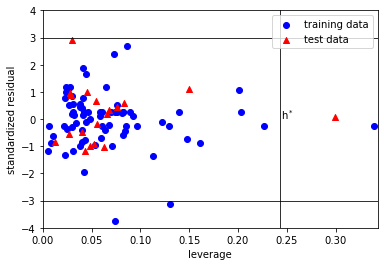

In [194]:
applicability_domain_rbf(scale_x_train, scale_x_test, y_train,
                     y_train_pred, y_test, y_test_pred)

<!-- ## Validation : Linear -->

In [13]:
%%DISBAND_VALID_SIGMOID_HEAD
## Validation : Sigmoid

UsageError: Cell magic `%%DISBAND_VALID_SIGMOID_HEAD` not found.


## Validation : Linear

### QSAR Param Linear

In [24]:
X_train = df_train.loc[:,desc].to_numpy()
X_test = df_test.loc[:,desc].to_numpy()
y_train = df_train.iloc[:,[-1]].to_numpy()
y_test = df_test.iloc[:,[-1]].to_numpy()

scaler = MinMaxScaler()
scaler.fit(X_train)
scale_x_train = scaler.transform(X_train)
scale_x_test = scaler.transform(X_test)

param_grid={
            'C': 1000,
            'degree': 1,
            'epsilon': 0.1
}

c = param_grid['C']
deg = param_grid['degree']
eps = param_grid['epsilon']

model = SVR(kernel="linear", C= c, degree= deg, epsilon=eps)

model.fit(scale_x_train, y_train)
y_train_pred = model.predict(scale_x_train)
y_test_pred = model.predict(scale_x_test)

q2 = q2_loo(model, scale_x_train, y_train)

# print RB Q2, Qsar_train, Qsar_test
q2

array([0.5397628])

In [25]:
val_train = pd.DataFrame(qsar_param(y_train, y_train_pred))
val_train

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.613803,1.138373,0.830362,0.265307,0.002001,0.161618,0.4792,0.226184


In [26]:
val_test = pd.DataFrame(qsar_param(y_test, y_test_pred))
val_test

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.631667,1.047116,0.845406,0.225732,0.000035,0.142566,0.510931,0.235571


### CR2p (Y_random) Sigmoid

In [23]:
rp_sig = y_random(model_sig,scale_x_train,y_train)
# joblib.dump(rp_lin,'./p/0005_n1/lin_crp2.pkl')
rp_sig

array([0.6019035])

### Applicability Domain Sigmoid

0.24324324324324326


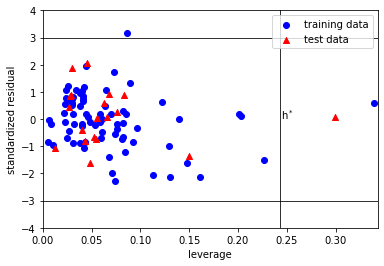

In [39]:
applicability_domain_lin(scale_x_train, scale_x_test, y_train,
                     y_train_pred, y_test, y_test_pred)

In [29]:
sig_valid = pd.DataFrame()
sig_valid = sig_valid.append(val_train)
sig_valid = sig_valid.append(val_test)
sig_valid.insert(1,'q2', [q2[0], q2[0]])
sig_valid['y_random'] = [rp_sig[0],rp_sig[0]]
# sig_valid.to_csv(r'./p/05_low/lin_val_revise.csv', index= None, header = True)
sig_valid

,r2,q2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2,y_random
0,0.613803,0.539763,1.138373,0.830362,0.265307,0.002001,0.161618,0.479200,0.226184,0.601903
0,0.631667,0.539763,1.047116,0.845406,0.225732,0.000035,0.142566,0.510931,0.235571,0.601903


## Validation : Polynomial

### QSAR Param Poly

In [207]:
X_train = df_train.loc[:,desc].to_numpy()
X_test = df_test.loc[:,desc].to_numpy()
y_train = df_train.iloc[:,[-1]].to_numpy()
y_test = df_test.iloc[:,[-1]].to_numpy()

scaler = MinMaxScaler()
scaler.fit(X_train)
scale_x_train = scaler.transform(X_train)
scale_x_test = scaler.transform(X_test)

param_grid={
            'C': 1000,
            'degree': 2,
            'epsilon': 0.1
}

c = param_grid['C']
deg = param_grid['degree']
eps = param_grid['epsilon']

model_pol = SVR(kernel="poly", C= c, degree= deg, epsilon=eps)
model_pol.fit(scale_x_train,y_train)
y_train_pred = model_pol.predict(scale_x_train)
y_test_pred = model_pol.predict(scale_x_test)

q2_poly = q2_loo(model_pol, scale_x_train, y_train)

# print RB Q2, Qsar_train, Qsar_test
q2_poly

array([0.57950353])

In [208]:
poly_val_train = pd.DataFrame(qsar_param(y_train, y_train_pred))
poly_val_train

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.720633,1.014031,0.954663,0.056917,0.010386,0.033532,0.616488,0.083601


In [209]:
poly_val_test = pd.DataFrame(qsar_param(y_test, y_test_pred))
poly_val_test

,r2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2
0,0.503317,0.957552,0.916523,0.095682,0.174224,0.039531,0.373568,0.038591


### CR2p (Y_random) Poly

In [210]:
rp_poly = y_random(model_pol,scale_x_train,y_train)
# joblib.dump(rp_poly, './p/0005_n1/poly_cr2p')
rp_poly

array([0.66610825])

### Applicability Domain Poly

0.24324324324324326


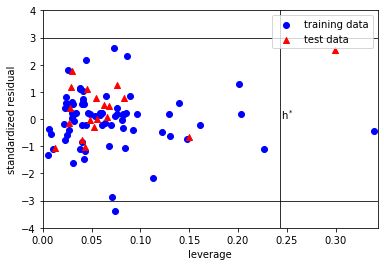

In [211]:
applicability_domain_poly(X_train, X_test, y_train,
                     y_train_pred, y_test, y_test_pred)

In [212]:
poly_valid = pd.DataFrame()
poly_valid = poly_valid.append(poly_val_train)
poly_valid = poly_valid.append(poly_val_test)
poly_valid.insert(1,'q2', [q2_poly[0], q2_poly[0]])
poly_valid['y_random'] = [rp_poly[0],rp_poly[0]]
# poly_valid.to_csv(r'./p/05_neue/poly_val_neue_20.csv', index= None, header = True)
poly_valid

,r2,q2,k,k_dash,r2r0,r2r0_dash,r0r0_dash,rm2_bar,d_rm2,y_random
0,0.720633,0.579504,1.014031,0.954663,0.056917,0.010386,0.033532,0.616488,0.083601,0.666108
0,0.503317,0.579504,0.957552,0.916523,0.095682,0.174224,0.039531,0.373568,0.038591,0.666108


# Graphs

## Preparing data

In [33]:
# data = pd.read_csv("data/all_data.csv")

# desc = joblib.load('./p/data/0005_10.pkl')
desc_raw = joblib.load('./p/05_low/raw_5.pkl')
df_train = joblib.load('./p/05_low/train.pkl')
df_test = joblib.load('./p/05_low/test.pkl')
pic = pd.read_csv("data/pIC50_target.csv")
df_pic = pic['pIC50']

ytrain =  df_train.iloc[:,[-1]]
ytest =  df_test.iloc[:,[-1]]

## Plot Temperature Vs. Mse

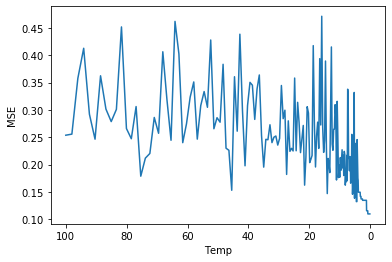

In [257]:
df = desc_raw.copy()
df.sort_values('MSE', inplace = True)

temp = df.iloc[0,3]
growth = df.iloc[0,2]

fig = plt.figure()
plt.plot(temp, growth)
plt.xlabel('Temp')
plt.ylabel('MSE')
# plt.ylim(0.1, 0.55)
plt.xlim(105,-5)
plt.savefig('./p/05_low/growth_mse_05.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()

## Plot MSE Vs. Num of Desc

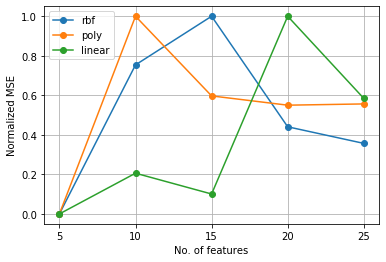

In [31]:
kernel_list = ["rbf", "poly", "sigmoid","linear"]
cv_lists = []
for kernel in kernel_list:
    tmp = joblib.load("./p/05_low/cv_list_{}.p".format(kernel))
    cv_lists.append(tmp)

opt_num = {}
cvs = []
x = [5,10,15,20,25]

sc = MinMaxScaler()
rb = list(cv_lists[0].values())
rb_np = np.asarray(rb)
rbf_sc = sc.fit_transform(rb_np.reshape(-1,1))
rbf_sc

sc = MinMaxScaler()
poly = list(cv_lists[1].values())
poly_np = np.asarray(poly)
poly_sc = sc.fit_transform(poly_np.reshape(-1,1))
poly_sc

sc = MinMaxScaler()
sig = list(cv_lists[2].values())
sig_np = np.asarray(sig)
sig_sc = sc.fit_transform(sig_np.reshape(-1,1))
sig_sc

sc = MinMaxScaler()
lin = list(cv_lists[3].values())
lin_np = np.asarray(lin)
lin_sc = sc.fit_transform(lin_np.reshape(-1,1))
lin_sc

plt.plot(x, rbf_sc, label='rbf', marker="o")
plt.plot(x, poly_sc, label='poly', marker="o")
# plt.plot(x, sig_sc, label='sigmoid', marker="o")
plt.plot(x, lin_sc, label='linear', marker="o")

plt.grid()
plt.xticks(x)
plt.xlabel("No. of features")
plt.ylabel("Normalized MSE")
plt.legend()
plt.savefig('./p/05_low/plot_nofeat_mse_withlinear.png', format='png', dpi=1000, bbox_inches="tight")
plt.show()

In [139]:
%% DISBAND_Plot MSE Vs. Num of Desc
# bd_list = []
# bd_5 = joblib.load('./p/0005_n1/raw_0005_5.pkl')
# bd_10 = joblib.load('./p/0005_n1/raw_0005_10.pkl')
# bd_15 = joblib.load('./p/0005_n1/raw_0005_15.pkl')
# bd_20 = joblib.load('./p/0005_n1/raw_0005_20.pkl')
# bd_25 = joblib.load('./p/0005_n1/raw_0005_25.pkl')
# bd_list.extend([bd_5,bd_10,bd_15,bd_20,bd_25])

# list_MSE = []
# x=[5,10,15,20,25]
# df_mse = pd.DataFrame(columns=['desc','mse'])

# for i in range(len(bd_list)):
#     bd_list[i].sort_values('MSE', inplace = True)
#     list_MSE.append(bd_list[i].iloc[0,0])
     
# df_mse['desc'] = [5,10,15,20,25]
# df_mse['mse'] = list_MSE

# fig, ax = plt.subplots()  # Create a figure and an axes.
# ax.set_xticks(x)

# plt.xlabel('Number of Descriptor')
# plt.ylabel('MSE')
# plt.plot(x, df_mse['mse'], marker='.' ,markersize=12)
# # plt.savefig('./graph/mse_numdesc_05_10.png', format='png', dpi=1000, bbox_inches="tight")    
# plt.show()

UsageError: Cell magic `%%` not found.


## Histogram pIC50

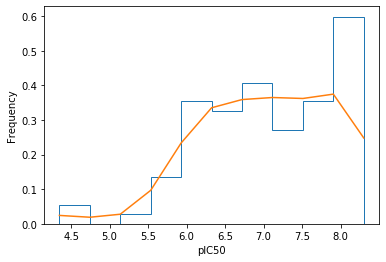

In [253]:
import scipy.stats as stats

df_target = pd.read_csv("data/pIC50_target.csv")

targets = df_target.iloc[:,1]

noise = targets
density = stats.gaussian_kde(noise)
n, x, _ = plt.hist(noise, histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.xlabel('pIC50')
plt.ylabel('Frequency')
# plt.savefig('./graph/hist_pic50.png', format='png', dpi=1000, bbox_inches="tight")
plt.show()

## Histogram MSE choosen desc

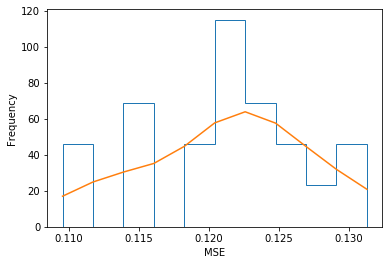

In [265]:
df = desc_raw.copy()
mse_temp = df.iloc[:,0]

noise = mse_temp
density = stats.gaussian_kde(noise)
n, x, _ = plt.hist(noise, histtype=u'step', density=True) 
plt.plot(x, density(x))
plt.xlabel('MSE')
plt.ylabel('Frequency')
# plt.savefig('./p/05_low/hist_mse_05.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()

## Plot For RBF

In [162]:
param_grid={
            'C': 10,
            'gamma': 'scale',
            'epsilon':0.1
}
c = param_grid['C']
gam = param_grid['gamma']
eps = param_grid['epsilon']

model = SVR(kernel="rbf", C= c, gamma= gam, epsilon=eps)
model.fit(scale_x_train, y_train)
y_train_pred = model.predict(scale_x_train)
y_test_pred = model.predict(scale_x_test)

ytr = ytrain.iloc[:,0]
ytr.tolist()
yts = ytest.iloc[:,0]
yts.tolist()

train_res = ytr - y_train_pred
test_res = yts - y_test_pred


### Actual Vs. Predict

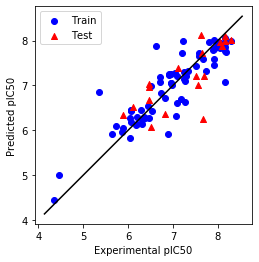

In [164]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(y_train, y_train_pred, color="b" , label='Train')
ax.scatter(y_test, y_test_pred, color="r" , label='Test',marker='^')
ax.legend(loc='top left')
# ax.plot([0, 1], [0, 1], color="black",transform=ax.transAxes)
dl = np.linspace(*ax.get_xlim())
ax.plot(dl, dl, color="black")
ax.set_aspect('equal')

plt.xlabel('Experimental pIC50')
plt.ylabel('Predicted pIC50')
# plt.title('RBF Actual Vs Predict')
plt.savefig('./p/05_low/actpred_rbf_05.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()

### Residual Plot

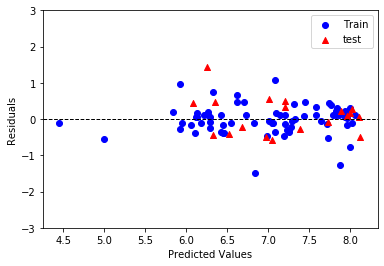

In [166]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(y_train_pred, train_res, color="b" , label='Train' ,marker='o')
ax.scatter(y_test_pred, test_res, color="red" , label='test' ,marker='^')
ax.legend(loc='top right')
ax.axhline(linewidth= 1, color='black', linestyle='dashed')
# plt.title('Residual SVR RBF')
plt.ylim(-3,3)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.savefig('./p/05_low/res_rbf_05_10.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()

## Plot For Sigmoid

In [34]:
param_grid={
            'C': 1000,
#             'gamma': 'auto',
            'degree' : 1,
            'epsilon': 0.1
}

model_sig = SVR(kernel="linear", C= param_grid['C'], degree = param_grid['degree'], epsilon = param_grid['epsilon'])
model_sig.fit(scale_x_train, y_train)
y_train_pred = model_sig.predict(scale_x_train)
y_test_pred = model_sig.predict(scale_x_test)

ytr = ytrain.iloc[:,0]
ytr.tolist()
yts = ytest.iloc[:,0]
yts.tolist()

train_res = ytr - y_train_pred
test_res = yts - y_test_pred

### Actual Vs. Predict

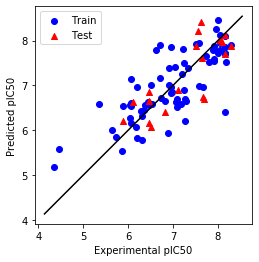

In [36]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(y_train, y_train_pred, color="b" , label='Train')
ax.scatter(y_test, y_test_pred, color="r" , label='Test',marker='^')
ax.legend(loc='top left')
# ax.plot([0, 1], [0, 1], color="black",transform=ax.transAxes)
dl = np.linspace(*ax.get_xlim())
ax.plot(dl, dl, color="black")
ax.set_aspect('equal')

plt.xlabel('Experimental pIC50')
plt.ylabel('Predicted pIC50')
# plt.title('RBF Actual Vs Predict')
plt.savefig('./p/05_low/actpred_linear_05.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()

### Residual Plot

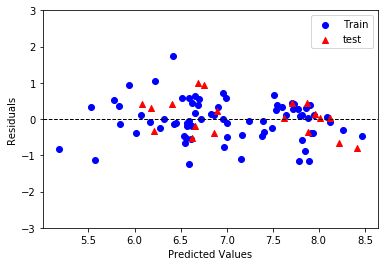

In [38]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(y_train_pred, train_res, color="b" , label='Train' ,marker='o')
ax.scatter(y_test_pred, test_res, color="red" , label='test' ,marker='^')
ax.legend(loc='top right')
ax.axhline(linewidth= 1, color='black', linestyle='dashed')
# plt.title('Residual SVR RBF')
plt.ylim(-3,3)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.savefig('./p/05_low/res_linear_05.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()

## Plot For Poly

In [172]:
param_grid={
            'C': 1000,
            'degree': 2,
            'epsilon': 0.1
}

c = param_grid['C']
deg = param_grid['degree']
eps = param_grid['epsilon']

modelPol = SVR(kernel="poly", C= c, degree= deg, epsilon=eps)
modelPol.fit(scale_x_train, y_train)
y_train_pred = modelPol.predict(scale_x_train)
y_test_pred = modelPol.predict(scale_x_test)

ytr = ytrain.iloc[:,0]
ytr.tolist()
yts = ytest.iloc[:,0]
yts.tolist()

train_res = ytr - y_train_pred
test_res = yts - y_test_pred

### Actual Vs. Predict

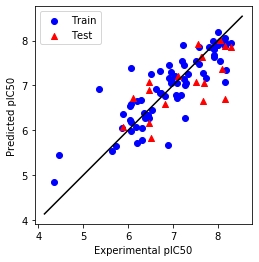

In [174]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(y_train, y_train_pred, color="b" , label='Train')
ax.scatter(y_test, y_test_pred, color="r" , label='Test',marker='^')
ax.legend(loc='top left')
# ax.plot([0, 1], [0, 1], color="black",transform=ax.transAxes)
dl = np.linspace(*ax.get_xlim())
ax.plot(dl, dl, color="black")
ax.set_aspect('equal')

plt.xlabel('Experimental pIC50')
plt.ylabel('Predicted pIC50')
# plt.title('RBF Actual Vs Predict')
plt.savefig('./p/05_low/actpred_poly_05.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()

### Residual Plot

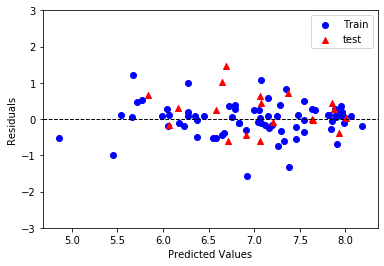

In [177]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(y_train_pred, train_res, color="b" , label='Train' ,marker='o')
ax.scatter(y_test_pred, test_res, color="red" , label='test' ,marker='^')
ax.legend(loc='top right')
ax.axhline(linewidth= 1, color='black', linestyle='dashed')
# plt.title('Residual SVR RBF')
plt.ylim(-3,3)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.savefig('./p/05_low/res_poly_05.png', format='png', dpi=1000, bbox_inches="tight")    
plt.show()